In [1]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from finite_tight_binding import TightBindingHamiltonian
from unit_cell_generation import UnitCell
import scipy.constants as spc
from plotter import BandStructurePlotter as plotter

In [2]:
import numpy as np
from math import factorial, sqrt
import scipy.constants
from scipy.special import sph_harm, genlaguerre
import fipy as fp

def _Rnl_array(n, l, r, a0=1.0):
    """Radial wave function"""
    pref = sqrt((2.0 / (n * a0))**3 * factorial(n - l - 1) /
                (2.0 * n * factorial(n + l)))
    rho = 2.0 * r / (n * a0)
    L = genlaguerre(n - l - 1, 2 * l + 1)      
    return pref * np.exp(-rho / 2.0) * rho**l * L(rho)

def _Ylm_array(l, m, dx, dy, dz, real=False):
    """Spherical harmonics Y_l^m"""
    r     = np.sqrt(dx*dx + dy*dy + dz*dz)
    theta = np.arccos(np.where(r == 0.0, 0.0, dz / r))
        
    phi   = np.arctan2(dy, dx)
    Y = sph_harm(m, l, phi, theta)      

    if real:
        if m > 0:
            Y = np.sqrt(2.) * (-1)**m * Y.real
        elif m < 0:
            Y = np.sqrt(2.) * (-1)**m * Y.imag
    return Y

def line_wavefunction(unitCell, eigv,
                      x0=0.25, y0=0.50,   
                      return_charge=True):
    Nz = unitCell.Nz
    z_coord = np.linspace(0.0, unitCell.N, Nz)   
    psi = np.zeros(Nz, dtype=np.complex128)

    orbital_qnums = {
        's' :(3,0, 0), 'px':(3,1,+1), 'py':(3,1,-1), 'pz':(3,1, 0),
        'dxy':(3,2,+2), 'dyz':(3,2,-1), 'dzx':(3,2,+1),
        'dx2y2':(3,2,-2), 'dz2':(3,2, 0), 's*':(4,0, 0)
    }
    orbitals = ['s','px','py','pz','dxy','dyz','dzx','dx2y2','dz2','s*']

    for atom_idx, atom in enumerate(unitCell.ATOM_POSITIONS):
        dx = x0 - atom.x
        dy = y0 - atom.y
        dz = z_coord - atom.z          
        r  = np.sqrt(dx*dx + dy*dy + dz*dz)

        for orb_idx, name in enumerate(orbitals):
            n, l, m = orbital_qnums[name]
            coeff   = eigv[atom_idx*10 + orb_idx]

            radial  = _Rnl_array(n, l, r)
            ang     = _Ylm_array(l, m,
                                 np.broadcast_to(dx, Nz),
                                 np.broadcast_to(dy, Nz),
                                 dz, real=False)

            psi += coeff * radial * ang

    if return_charge:
        q = -scipy.constants.elementary_charge
        return z_coord, q * np.abs(psi)**2
    else:
        return z_coord, psi


def _grid_to_cell_coords(Nx, Ny, Nz, N):
    gx, gy, gz = np.meshgrid(np.arange(Nx),
                             np.arange(Ny),
                             np.arange(Nz),
                             indexing="ij")
    fx = gx / (Nx - 1)              
    fy = gy / (Ny - 1)
    xs = (np.sqrt(2) / 4.0) * fx
    ys = (np.sqrt(2) / 4.0) * fy
    xr = xs - np.sqrt(2) / 8.0
    yr = ys - np.sqrt(2) / 8.0
    cos_t =  np.cos(3*np.pi/4)    
    sin_t =  np.sin(3*np.pi/4)  
    x_shift =  cos_t * xr - sin_t * yr
    y_shift =  sin_t * xr + cos_t * yr
    x_cell = x_shift + 0.25
    y_cell = y_shift + 0.50
    z_cell = gz * N / (Nz - 1)     
    return x_cell, y_cell, z_cell
def fillInGrid_vectorised(unitCell, eigv):
    """Return complex wave‑function values on the whole unit‑cell grid."""
    Nx, Ny, Nz = unitCell.Nx, unitCell.Ny, unitCell.Nz
    x, y, z = _grid_to_cell_coords(Nx, Ny, Nz, unitCell.N)

    psi = np.zeros_like(x, dtype=np.complex128)


 
    orbital_qnums = {
        's'     :(3,0, 0),  'px'   :(3,1,+1), 'py'   :(3,1,-1), 'pz'   :(3,1, 0),
        'dxy'   :(3,2,+2),  'dyz'  :(3,2,-1), 'dzx'  :(3,2,+1),
        'dx2y2' :(3,2,-2),  'dz2'  :(3,2, 0), 's*'   :(4,0, 0)
    }
    orbitals = ['s','px','py','pz','dxy','dyz','dzx','dx2y2','dz2','s*']

    for atom_index, atom in enumerate(unitCell.ATOM_POSITIONS):
        Ra = np.asarray([atom.x, atom.y, atom.z])
        dx = x - Ra[0]
        dy = y - Ra[1]
        dz = z - Ra[2]
        r  = np.sqrt(dx*dx + dy*dy + dz*dz) 

        for orb_index, name in enumerate(orbitals):
            n, l, m = orbital_qnums[name]
            coeff   = eigv[atom_index*10 + orb_index]

            radial  = _Rnl_array(n, l, r)
            ang     = _Ylm_array(l, m, dx, dy, dz, real=False) 

            psi += coeff * radial * ang

    return psi   
def wavefunction_grid(unitCell, eigv):
    return fillInGrid_vectorised(unitCell, eigv)  

def charge_density_grid(unitCell, eigv):
    psi = wavefunction_grid(unitCell, eigv)
    q   = -scipy.constants.elementary_charge 
    rho = q * np.abs(psi)**2  
    return rho

def modifyForVoltage(rho):
    rho_x = np.concatenate((rho[::-1, :, :], rho), axis=0)      
    rho_xy = np.concatenate((rho_x[:, ::-1, :], rho_x), axis=1)   
    rho_sym = 0.5 * (rho_xy + rho_xy.transpose(1, 0, 2))
    print(rho_sym.shape)
    return rho_sym
    

def solvePoisson(rho_data, Vg):
    Nx,Ny,Nz = rho_data.shape
    dx,dy,dz = 1 / (Nx - 1), 1 / (Ny - 1), 1 / (Nz - 1)
    mesh = fp.meshes.periodicGrid3D.\
       PeriodicGrid3DLeftRightFrontBack(
           dx=dx, dy=dy, dz=dz, nx=Nx, ny=Ny, nz=Nz)
    phi  = fp.CellVariable(mesh=mesh, name="phi")          # potential
    rho  = fp.CellVariable(mesh=mesh,                     # charge density
                        value=rho_data.ravel())        # ← your data
    eps0 = 8.854e-12    
    eq = fp.DiffusionTerm(coeff=1.0) == -rho/eps0

    # Dirichlet on bottom (z=0) and top (z=Lz)
    phi.constrain(Vg, mesh.facesBottom)                  # V = 0  bottom
    phi.constrain(-Vg, mesh.facesTop)                     # V = 0.1 top

    eq.solve(var=phi, solver=fp.LinearLUSolver())

    return np.asarray(phi.value).reshape(rho_data.shape)


In [3]:
TB = TightBindingHamiltonian(4)
a = 1.0
G  = np.array([0, 0])
K  = np.array([1/2, 1/2])
W  =np.array([-1,0])

# plot
plotter = plotter(TB)
plotter.build_k_path([W, G, K], points_per_segment=200)


unitCell = TB.unitCell
unitCell.setGrid(10,10,20)
for i in range(5):
    cbmEv,cbmVec, vbmEV,vbmVec = TB.getBandValues(k=np.array([0,0]))
    rho = charge_density_grid(unitCell, cbmVec)
    rho_prime = modifyForVoltage(rho)
    phi = solvePoisson(rho_prime, 1)
    TB.unitCell.setVoltage(phi)

    TB.modifySigma(cbmEv,cbmVec, vbmEV,vbmVec)




/tmp/ipykernel_1650457/1375482136.py:18: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(np.where(r == 0.0, 0.0, dz / r))
/tmp/ipykernel_1650457/1375482136.py:21: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y = sph_harm(m, l, phi, theta)


(20, 20, 20)
(1.70245692738757+0j)


/home/nandan_diwan/Desktop/NEGF_sim/NEGF_sim_git/src/tight_binding/finite_tight_binding.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  evals -= np.float64(sigma)
/home/nandan_diwan/Desktop/NEGF_sim/NEGF_sim_git/src/tight_binding/finite_tight_binding.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  return cbm_E + np.float64(sigma), cbm_vec, vbm_E + np.float64(sigma), vbm_vec


(20, 20, 20)
(2.0850782974539603+0j)
(20, 20, 20)
(2.0850782974539364+0j)
(20, 20, 20)
(2.0850782974539355+0j)
(20, 20, 20)
(2.085078297453936+0j)


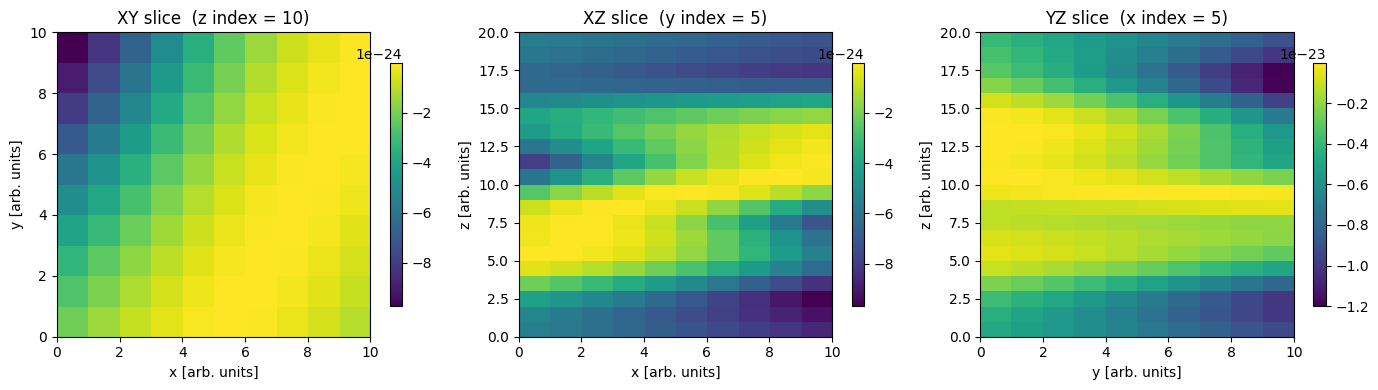

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rho_slices(rho, *, dx=1.0, dy=1.0, dz=1.0):
    """
    Visualise a 3‑D scalar field by showing its central XY, XZ and YZ slices.

    Parameters
    ----------
    rho : ndarray  (nx, ny, nz)
        Charge‑density (or any) field on a regular Cartesian grid.
    dx, dy, dz : float, optional
        Physical spacings of the grid (used only for axis labelling).
    """
    if rho.ndim != 3:
        raise ValueError("rho must be a 3‑D array")

    nx, ny, nz = rho.shape
    ix, iy, iz = nx // 2, ny // 2, nz // 2        # central indices

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # --- XY slice at mid‑Z ------------------------------------------------
    im0 = axes[0].imshow(rho[:, :, iz].T, origin="lower",
                         extent=[0, nx*dx, 0, ny*dy], aspect="auto")
    axes[0].set_title(f"XY slice  (z index = {iz})")
    axes[0].set_xlabel("x [arb. units]")
    axes[0].set_ylabel("y [arb. units]")
    fig.colorbar(im0, ax=axes[0], shrink=0.8)

    # --- XZ slice at mid‑Y ------------------------------------------------
    im1 = axes[1].imshow(rho[:, iy, :].T, origin="lower",
                         extent=[0, nx*dx, 0, nz*dz], aspect="auto")
    axes[1].set_title(f"XZ slice  (y index = {iy})")
    axes[1].set_xlabel("x [arb. units]")
    axes[1].set_ylabel("z [arb. units]")
    fig.colorbar(im1, ax=axes[1], shrink=0.8)

    # --- YZ slice at mid‑X ------------------------------------------------
    im2 = axes[2].imshow(rho[ix, :, :].T, origin="lower",
                         extent=[0, ny*dy, 0, nz*dz], aspect="auto")
    axes[2].set_title(f"YZ slice  (x index = {ix})")
    axes[2].set_xlabel("y [arb. units]")
    axes[2].set_ylabel("z [arb. units]")
    fig.colorbar(im2, ax=axes[2], shrink=0.8)

    plt.tight_layout()
    plt.show()


plot_rho_slices(rho)

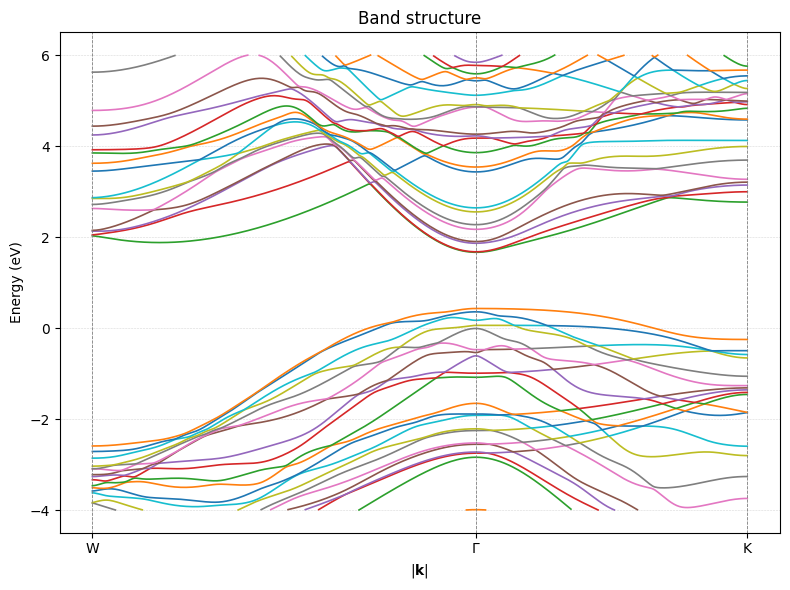

In [5]:


# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-4, 6),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})
